# Binary star evolution and binary black holes

Giacomo Menegatti, Dario Puggioni, Laura Schulze, Savina Tsichli

## Introduction

A binary black hole can originate from the evolution of a massive binary star. During its life,
a tight massive binary star undergoes several complex physical processes: the two stars can
exchange mass either via stable mass transfer or via a common envelope. This has a profound
impact on the final masses and orbital properties of the binary black hole.  

This project aims to differentiate binary black hole systems that evolved via stable mass transfer from those who evolved via common envelop by investigating simulation data. In each dataset of the simulated data, systems which underwent common envelope are marked with "True" and systems which underwent stable mass transfer are marked with "False" in the "CE" parameter. The data are analyzed to identify the features with the highest impact on the evolution of the binary system regarding mass transfer and common envelope. For this purpose, the biserial correlation as well as the parameter importances in a machine learning model are investigated.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import regex as re
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [ ]:
from posix import pathconf_names
from google.colab import drive
drive.mount('/content/gdrive')
import os
path = '/content/gdrive/MyDrive'
os.chdir(path)

## Loading the dataset
The dataset is divided in files depending on the CE efficiency $ \alpha $ and the metallicity $ Z $ of the two stars. All the data are loaded into a pandas dataframe containing also the two parameters. The following table contains the parameter names, units and descriptions.


| Column name | Unit | Parameter description |
|------|------|------|
| m1ZAMS | $M_\odot$ | zero-age main sequence mass of the primary member of the binary system |
| m2ZAMS | $M_\odot$ | zero-age main sequence mass of the secondary member of the binary system |
| m1rem | $M_\odot$ | mass of the black hole that forms from the primary member |
| m2rem | $M_\odot$ | mass of the black hole that forms from the secondary member |
| m1rem+m2rem | $M_\odot$ |  sum of the masses of the two black holes |
| delay_time | Myr | delay time |
| sma | $R_\odot$ | semi-major axis of the binary system at the formation of the second-born black hole |
| ecc | - | orbital eccentricity of the binary system at the formation of the second-born black hole | kick_1 | km/a | magnitude of the supernova kick associated with the primary member |
| kick_2 | km/s | magnitude of the supernova kick associated with the secondary member |
| cmu1 | - | cosine of the tilt angle between the orbital angular momentum of the binary system before and after the supernova explosion of the primary member |
| cmu2 | - | cosine of the tilt angle between the orbital angular momentum of the binary system before and after the supernova explosion of the secondary member |
| v1x | km/s | x component of the centre-of-mass velocity of the binary system after the supernova explosion of the primary component |
| v1y | km/s |  y component of the centre-of-mass velocity of the binary system after the supernova explosion of the primary component |
| v1z | km/s | z component of the centre-of-mass velocity of the binary system after the supernova explosion of the primary component |
| v2x | km/s | x component of the centre-of-mass velocity of the binary system after the supernova explosion of the secondary component |
| v2y | km/s | y component of the centre-of-mass velocity of the binary system after the supernova explosion of the secondary component |
| v2z | km/s | z component of the centre-of-mass velocity of the binary system after the supernova explosion of the secondary component |
| time_SN1 | Myr | time at which the primary component undergoes a supernova |
| time_SN2 | Myr | time at which the secondary component undergoes a supernova |
| CE | - | Boolean variable indicating whether the binary system undergoes a common envelope (True) |
| alpha | - | efficiency parameter of common envelope |
| Z | - | stellar metallicity at which the black holes were produced |

In [2]:
alpha = [0.5, 1, 3, 5] # CE efficiency
Z = [2e-4, 4e-4, 8e-4, 1.2e-3, 1.6e-3, 2e-3, 4e-3, 6e-3, 8e-3, 1.2e-2, 1.6e-2, 2e-2]  #Metallicity value

data = [] #Data list

sim_data = pd.DataFrame({'alpha':[], 'Z':[], 'MtotZAMS':[], 'num_mergers':[]})
#Appending all the values in a single big dataframe

index = 0
for a in alpha:
    for m in Z:
        # The simulation data first row contains the MtotZAMS and the number of merger for each alpha and metallicity
        df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', sep=' ', nrows = 1, header=0)
        sim_data.loc[index] = [a, m, df.iloc[0,0], df.iloc[0,1]]  #Adding the row to the sim_data df
        index = index + 1

        df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', header=2, sep= ' ')     # Simulation data
        df['alpha'],df['Z'] = a, m                                 #Adding the alpha and Z paramtere in the table

        data.append(df)

data = pd.concat(data)
data.columns = [re.sub('col.*:|/.*$', '', name) for name in data.columns]

# separate the kick columns
data.columns.values[9] = 'kick_1'
data.columns.values[10] = 'kick_2'

# switch vx and kick columns
data["kick_1"], data["v1x"] =  data["v1x"], data["kick_1"]
data["kick_2"], data["v2x"] =  data["v2x"], data["kick_2"]

# Drop the ID column
data = data.drop(columns="ID")

print('Data columns: \n ', data.columns.values)
data.reset_index(drop=True,inplace=True)
data


Data columns: 
  ['m1ZAMS' 'm2ZAMS' 'm1rem' 'm2rem' 'm1rem+m2rem' 'delay_time' 'sma' 'ecc'
 'kick_1' 'kick_2' 'cmu1' 'cmu2' 'v1x' 'v1y' 'v1z' 'v2x' 'v2y' 'v2z'
 'time_SN1' 'time_SN2' 'CE' 'alpha' 'Z']


,m1ZAMS,m2ZAMS,m1rem,m2rem,m1rem+m2rem,delay_time,sma,ecc,kick_1,kick_2,...,v1y,v1z,v2x,v2y,v2z,time_SN1,time_SN2,CE,alpha,Z
0,24.1323,17.1893,9.5692,5.0020,14.5712,141.1783,5.1703,0.258940,10.340,159.00,...,-14.2600,12.3200,66.8706,14.410,-16.0800,8.826,13.340,True,0.5,0.0002
1,69.5474,64.3689,28.4847,39.1186,67.6033,9.2023,6.4328,0.055966,1.263,33.43,...,0.0000,-0.0000,0.0000,0.000,0.0000,4.270,5.594,True,0.5,0.0002
2,106.6977,41.0318,39.9392,38.2094,78.1486,2223.2639,35.8880,0.041435,14.120,13.65,...,0.0000,0.0000,0.0000,-0.000,-0.0000,3.722,6.271,False,0.5,0.0002
3,74.3594,54.3256,30.1523,37.4020,67.5543,8.7628,6.0720,0.041342,1.621,26.89,...,0.0000,0.0000,0.0000,0.000,-0.0000,4.163,5.917,True,0.5,0.0002
4,116.6000,63.2642,41.9604,42.9817,84.9421,2636.2197,40.0410,0.079504,14.000,25.05,...,0.0000,-0.0000,0.0000,0.000,-0.0000,3.645,5.581,False,0.5,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963577,49.5343,41.7016,4.9807,4.6760,9.6567,10772.9297,11.8280,0.251980,105.800,106.80,...,-4.5470,-12.3800,53.1911,-11.690,-4.2940,4.938,5.526,True,5.0,0.0200
2963578,89.2801,62.1861,7.3304,5.1195,12.4499,16.0614,462.4200,0.999370,10.970,31.54,...,-0.4379,7.7350,55.8316,-1.229,0.1420,4.100,4.566,True,5.0,0.0200
2963579,36.4361,27.1551,4.0565,3.2400,7.2965,2200.2712,212.1500,0.993170,4.844,57.32,...,-1.7630,2.3040,103.5057,-25.490,2.6910,5.870,8.173,True,5.0,0.0200
2963580,73.1220,37.7591,8.2607,4.8831,13.1438,6547.9141,302.6300,0.988970,2.550,40.58,...,1.4470,-0.7723,80.6920,-8.732,2.6860,4.282,6.396,True,5.0,0.0200


In [3]:
N_data = data.shape[0]

CE_data = data.query('CE == True').shape[0]
MT_data = data.query('CE == False').shape[0]
print(f'There are {CE_data} ({CE_data/N_data * 100:.2f}%) BBHs evolving from common envelope, and {MT_data} ({MT_data/N_data * 100:.2f}%) BBHs evolving from mass transfer, for a total of {N_data} BBHs')


There are 2551001 (86.08%) BBHs evolving from common envelope, and 412581 (13.92%) BBHs evolving from mass transfer, for a total of 2963582 BBHs


## Investigating biserial correlation of the parameters

In this section the point biserial correlation is calculated for each feature with respect to the binary parameter "CE". This value can range from -1 to 1 and indicates the grade of a possible correlation between data and a binary condition. A value of zero means there is no correlation, a value of (-)1 means that there is a perfect direct (inverse) correlation. If the data of a feature are distributed equally with respect to the binary condition, the correlation is 0; when data are perfectly separated the value of the biserial correlation is $\pm 1$.

In [4]:
numeric_columns = data.drop(columns="CE")
correlation_dict = {}
for column in numeric_columns:
    correlation = data[column].corr(data['CE'])
    correlation_dict[column] = correlation
correlation_df=pd.DataFrame(correlation_dict,index=['Correlation']).T
correlation_df.sort_values(by='Correlation',key=abs,ascending=False)


,Correlation
m1ZAMS,-0.462425
m1rem,-0.450506
time_SN1,0.396096
m1rem+m2rem,-0.383408
m2rem,-0.306382
v1x,0.254945
time_SN2,0.251870
delay_time,-0.220924
ecc,0.215878
v2x,0.202675


Histograms of the normalized distribution of the data for each features are shown, plotting them with a different color for the binary condition "CE". In order to improve the visualization, for some of these histograms a logarithmic scale is used for the counts.

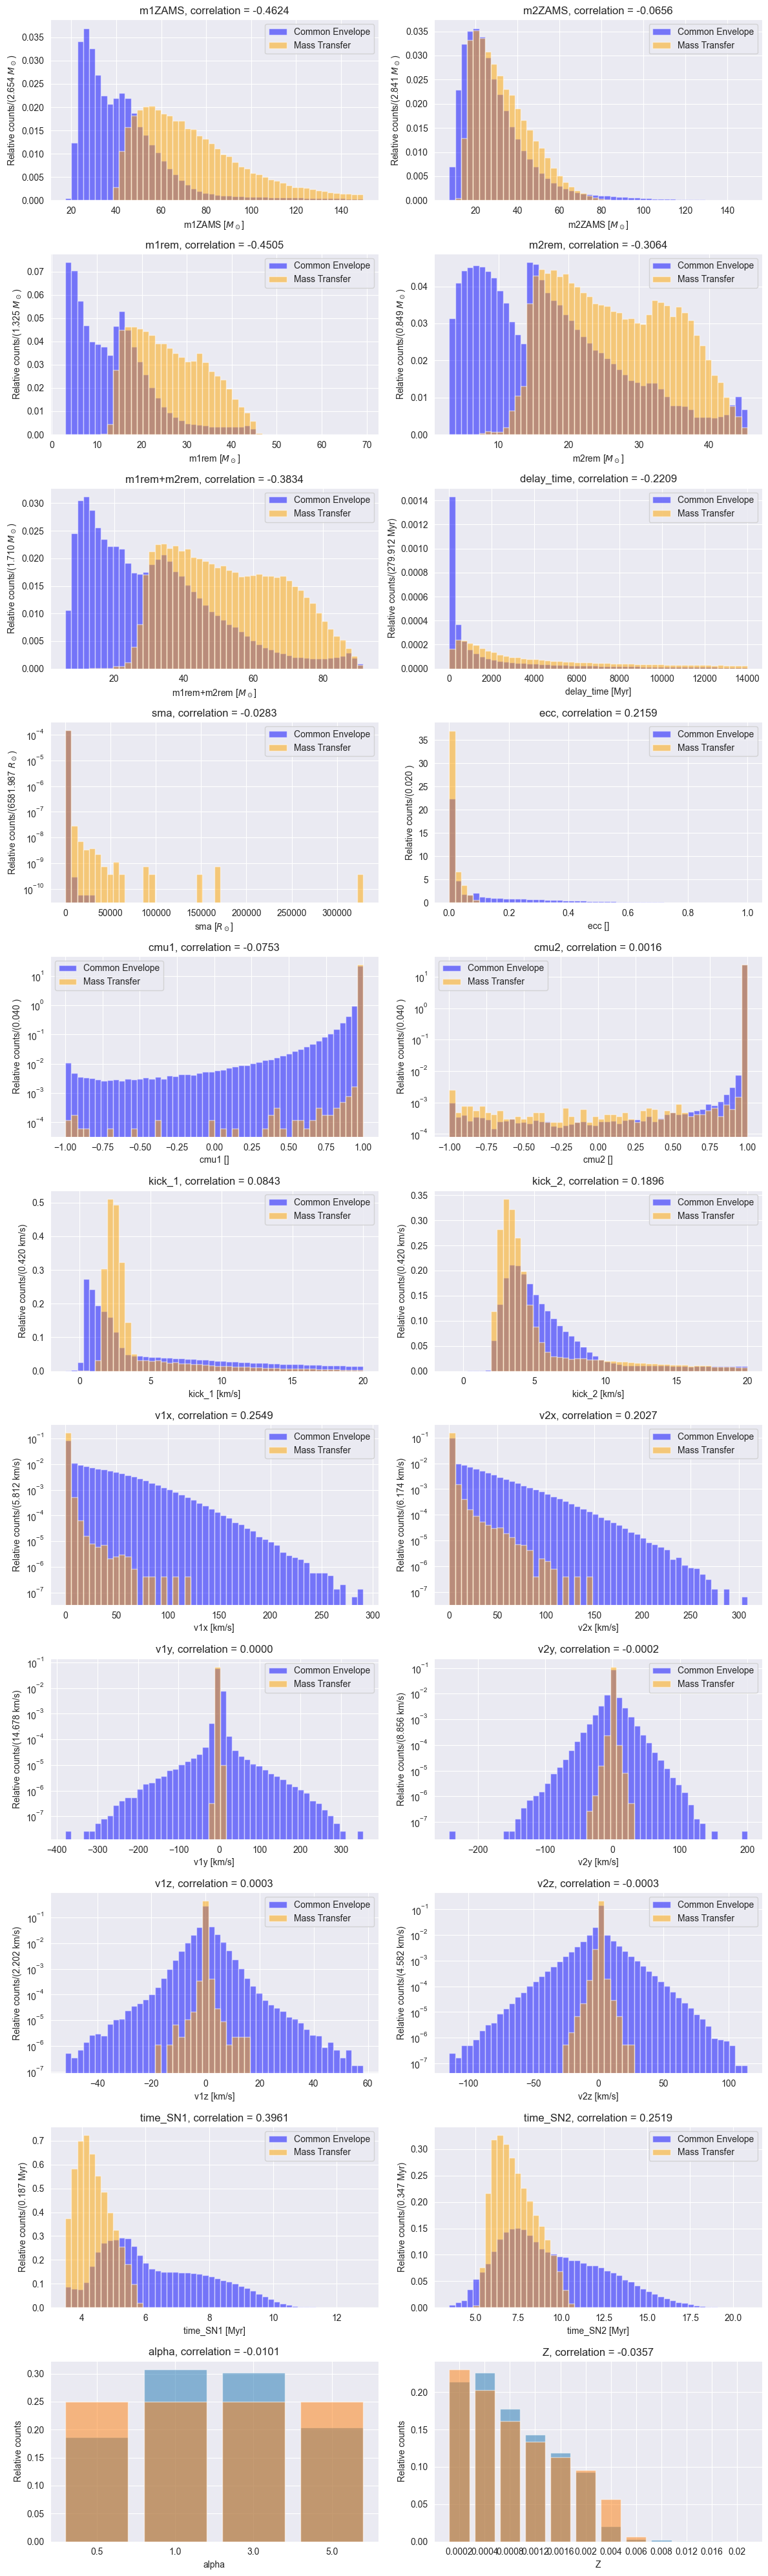

In [5]:
# Function to plot the parameters (only for continue distributions)
def plot_continue(ax, feature, uom='', bins = 50, hist_range=None, log=False):
    if hist_range == None:
        hist_range = (data[feature].min(), data[feature].max())
    bin_width = (hist_range[1]-hist_range[0])/bins
    data[data.CE == True][feature].hist(bins = bins, range = hist_range, color='blue', alpha=0.5, label='Common Envelope', ax=ax,density=True, log=log)
    data[data.CE == False][feature].hist(bins = bins, range = hist_range,color='orange', alpha=0.5, label='Mass Transfer', ax=ax,density=True, log=log)
    ax.legend(loc='best')
    ax.set_xlabel(f'{feature} [{uom}]')
    ax.set_ylabel(f'Relative counts/({bin_width:.3f} {uom})')
    ax.set_title(f'{feature}, correlation = {correlation_dict[feature]:.4f}')
    return ax

def plot_discrete(ax, feature):
    # Function to plot a discrete variable

    labels_CE, counts_CE = np.unique(data[data['CE'] == True][feature], return_counts= True)
    # Making the labels strings so they are equally spaced on the plot
    labels_CE = [str(x) for x in labels_CE]

    labels_MT, counts_MT = np.unique(data[data['CE'] == False][feature], return_counts= True)
    labels_MT = [str(x) for x in labels_MT]
    ax.bar(labels_CE, counts_CE/CE_data, alpha=0.5)
    ax.bar(labels_MT, counts_MT/MT_data, alpha=0.5)
    ax.set_ylabel(f'Relative counts')
    ax.set_xlabel(f'{feature}')
    ax.set_title(f'{feature}, correlation = {correlation_dict[feature]:.4f}')
    return ax


fig, axs = plt.subplots(nrows=11, ncols=2, figsize=(12, 40))

ax = plot_continue(axs[0,0], 'm1ZAMS', '$M_\odot$')
ax = plot_continue(axs[0,1], 'm2ZAMS', '$M_\odot$')
ax = plot_continue(axs[1,0], 'm1rem', '$M_\odot$')
ax = plot_continue(axs[1,1], 'm2rem', '$M_\odot$')
ax = plot_continue(axs[2,0], 'm1rem+m2rem', '$M_\odot$')
ax = plot_continue(axs[2,1], 'delay_time', 'Myr')
ax = plot_continue(axs[3,0], 'sma', '$R_\odot$', log=True)
ax = plot_continue(axs[3,1], 'ecc', '')
ax = plot_continue(axs[4,0], 'cmu1', '', log=True)
ax = plot_continue(axs[4,1], 'cmu2', '', log=True)
ax = plot_continue(axs[5,0], 'kick_1', 'km/s', hist_range=(-1, 20))
ax = plot_continue(axs[5,1], 'kick_2', 'km/s', hist_range=(-1,20))
ax = plot_continue(axs[6,0], 'v1x', 'km/s', log=True)
ax = plot_continue(axs[6,1], 'v2x', 'km/s', log=True)
ax = plot_continue(axs[7,0], 'v1y', 'km/s',  log=True)
ax = plot_continue(axs[7,1], 'v2y', 'km/s',  log=True)
ax = plot_continue(axs[8,0], 'v1z', 'km/s', log=True)
ax = plot_continue(axs[8,1], 'v2z', 'km/s', log=True)
ax = plot_continue(axs[9,0], 'time_SN1', 'Myr')
ax = plot_continue(axs[9,1], 'time_SN2', 'Myr')

#Plotting alpha and Z

ax = plot_discrete(axs[10,0], 'alpha')
ax = plot_discrete(axs[10,1], 'Z')

plt.tight_layout()
plt.show()


### Analyzing the correlation between parameters
Only the upper diagonal part is kept to make visualization easier

<Axes: >

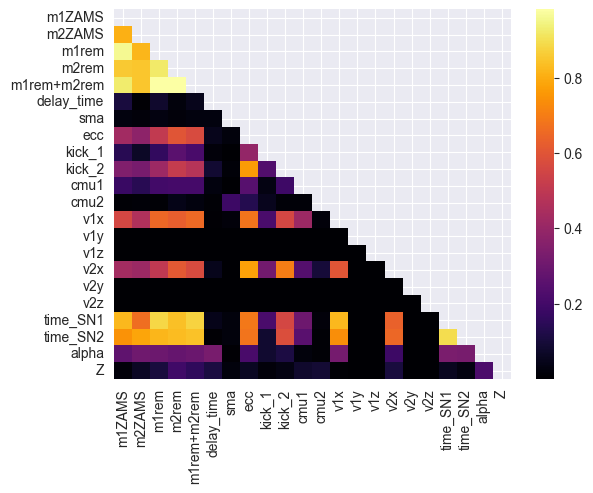

In [6]:
data_corr = data.drop(columns='CE')
corr_matrix = data_corr.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(np.abs(corr_matrix), mask=mask, cmap='inferno', linecolor='w')#annot = true to display the values


## Investigating parameter importance through Machine Learning
In the following section, the importance of the parameters is examined further by evaluating a machine learning model.
First, a Random Forest model is trained on the simulation data to predict whether a system evolves via common envelope or not. Then, the impact of the different parameters on the model and its prediction accuracy is investigated.

### Training the Random Forest Model
The Random Forest was implemented using the `RandomForestClassifier` from the sklearn.ensemble module. As per default, the Random Forest consists of 100 decision trees. It is trained using a 10%-subset of the simulation data, and the prediction accuracy is tested using the remaining 90% of the data. A test accuracy of approx. 99.8% is achieved.

In [7]:
# prepare data X and labels y
X = data.drop(columns='CE')
y = data['CE']

# split data into training and test set (10% to 90%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.9, random_state=100)


In [8]:
# initialise random forest classifier
# using n_jobs=-1 to run parallel jobs using all processors
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# time the process
ts = time.time()
clf.fit(X_train, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)


Training time: 19.64 s
Training accuracy:  1.0
Test accuracy:  0.99841258177041


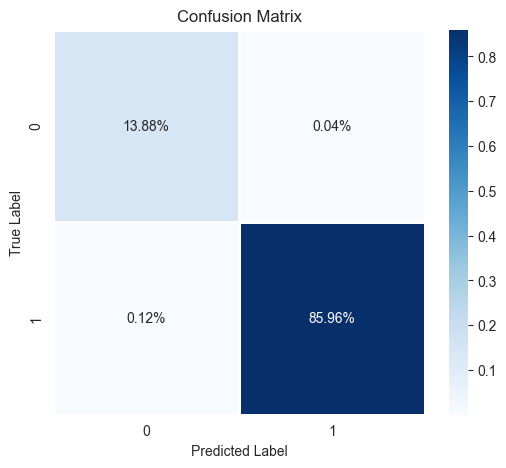

In [9]:
from sklearn import metrics

def show_confusion_matrix(validations, predictions,perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    sns.heatmap(M, annot=True, fmt=f, linecolor='white', linewidths=1, cmap=cmap)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


show_confusion_matrix(y_test, clf.predict(X_test), perc=True)

### Analyzing feature importance
After training a model that predicts with a satisfactory accuracy, the importance of the features is evaluated using two different metrics; the Gini importance and the Permutation importance.
The Gini importance is based on the decrease in impurity, whereas the permutation importance is based on the mean decrease in accuracy.

#### Gini importance
The Gini importance of a feature is estimated through the weighted impurity decrease at the nodes where the feature is used to split samples in the decision trees. In scikit-learn, the Gini importances are available through the `feature_importances_`-attribute of the `RandomForestClassifier`.

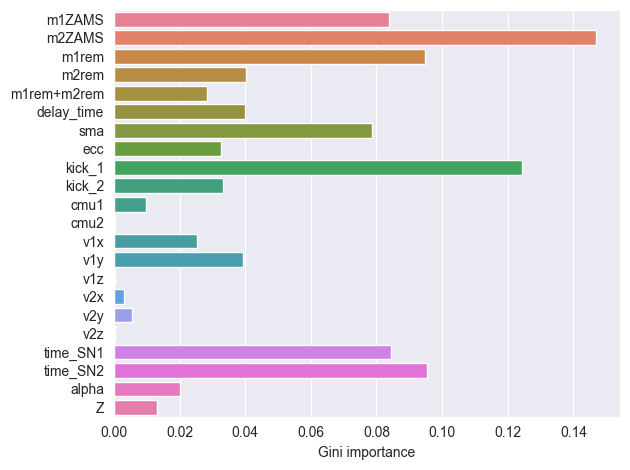

In [10]:
# save params + importances to dataframe
importances = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_),
                           columns=["param", "gini"])
# plot Gini importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='gini', data=importances, ax=ax, hue='param')
ax.set_ylabel('')
ax.set_xlabel('Gini importance')
fig.tight_layout()
plt.show()


## Adding noise channels to have a reference of Gini importance

In this part of the analysis we add a column of pure noise to have a reference in the plot

Training time: 29.20 s
Training accuracy:  1.0
Test accuracy:  0.9983732149980654


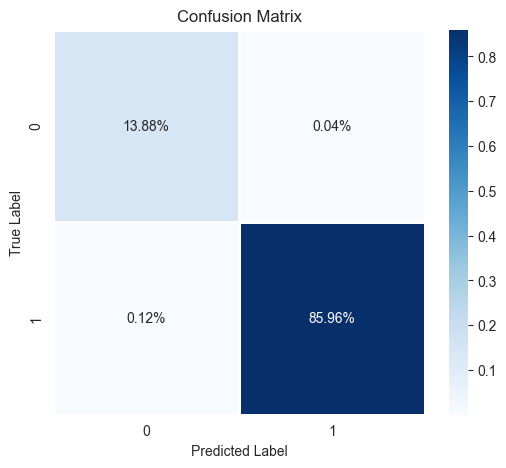

In [11]:
X_noise = X.copy()
X_noise['noise'] = np.random.normal(0, 1, size = N_data)

# split data into training and test set (10% to 90%)
X_train_noisy, X_test_noisy, y_train, y_test = train_test_split(X_noise, y, stratify=y, test_size=0.9, random_state=100)

# initialise random forest classifier
# using n_jobs=-1 to run parallel jobs using all processors
clf_noisy = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# time the process
ts = time.time()
clf_noisy.fit(X_train_noisy, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc = clf_noisy.score(X_train_noisy, y_train)
test_acc = clf_noisy.score(X_test_noisy, y_test)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)
show_confusion_matrix(y_test, clf_noisy.predict(X_test_noisy), perc=True)


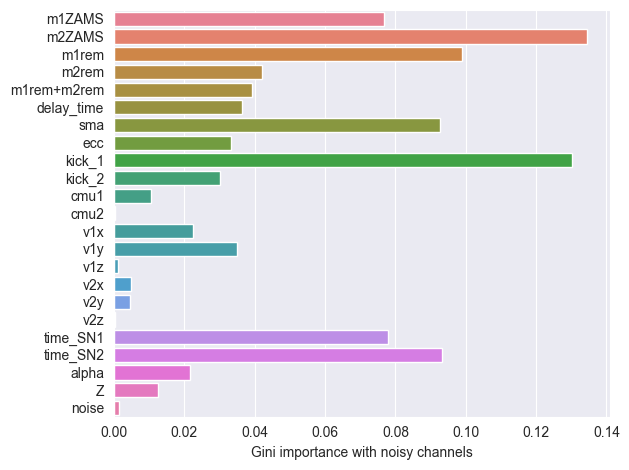

In [12]:
# save params + importances to dataframe
importances_noisy = pd.DataFrame(zip(clf_noisy.feature_names_in_, clf_noisy.feature_importances_),columns=["param", "gini"])
# plot Gini importances
fig, ax = plt.subplots()
clrs = ['r' if (param == 'noise') else 'b' for param in clf_noisy.feature_names_in_]
sns.barplot(y='param', x='gini', data=importances_noisy, ax=ax, hue='param')
ax.set_ylabel('')
ax.set_xlabel('Gini importance with noisy channels')
fig.tight_layout()
plt.show()

### WHAT CAN WE SAY ABOUT THE NOISY CLF

#### Permutation Feature Importance
The permutation importance of a feature describes the mean decrease in accuracy when the values of that feature are randomly permutated, and is computed using out-of-bag samples. Here, the permutation feature importances were calculated with the test data set using the `sklearn.inspection.permutation_importance` method.

As the computation of the permutation importance using the entire test set takes a lot of time, a subset corresponding to 10% of the total data was chosen from the test set. Furthermore, the number of repetitions `n_repeats` was set to 5 to limit the computation time as well.

In [13]:
# compute permutation feature importances
# warning: takes a lot of time to compute!
ts = time.time()
result = permutation_importance(clf, X_test[::10], y_test[::10], n_repeats=5, random_state=0, n_jobs=-1)
print("importance calculation time: {:.2f} s".format(time.time() - ts))
# save importances to DataFrame
importances['permutation'] = result.importances_mean
importances_stds = result.importances_std


importance calculation time: 103.41 s


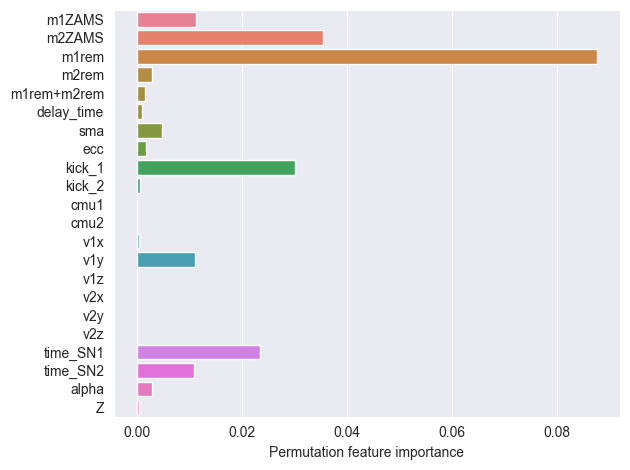

In [14]:
# plot permutation importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='permutation', data=importances, ax=ax, hue='param')
ax.set_ylabel('')
ax.set_xlabel('Permutation feature importance')
fig.tight_layout()
plt.show()

## Comparison of feature importances

After investigating the biserial correlation, the Gini importance and the permutation importance, the obtained results are now compared.

The following table highlights the 5 highest absolute values in each of the importance measures.

In [15]:
# add biserial correlation
importances["biserial"] = correlation_df["Correlation"].values

# highlight 5 highest importances in each column
styled_importances = (importances
                      .style
                      .apply(lambda col: ['background-color: skyblue' if (col.dtype==float and abs(val) in col.abs().nlargest(5).values) else '' for val in col],
                             axis=0))

# Visualizzare il DataFrame con lo stile applicato
styled_importances


,param,gini,permutation,biserial
0,m1ZAMS,0.083858,0.011155,-0.462425
1,m2ZAMS,0.146865,0.035414,-0.065608
2,m1rem,0.094671,0.087688,-0.450506
3,m2rem,0.040267,0.002822,-0.306382
4,m1rem+m2rem,0.028392,0.001500,-0.383408
5,delay_time,0.040037,0.000860,-0.220924
6,sma,0.078775,0.004663,-0.028308
7,ecc,0.032759,0.001611,0.215878
8,kick_1,0.124279,0.030129,0.084345
9,kick_2,0.033194,0.000553,0.189565


In order to compare the importances more easily, each importance measure is normalized so that the absolute values summed over all features add up to one. The Gini importance is normalized this way per default; permutation importance and biserial correlation were adjusted accordingly, even if biserial correlation is not proper measure for compare features, but it´s useful for single feature.

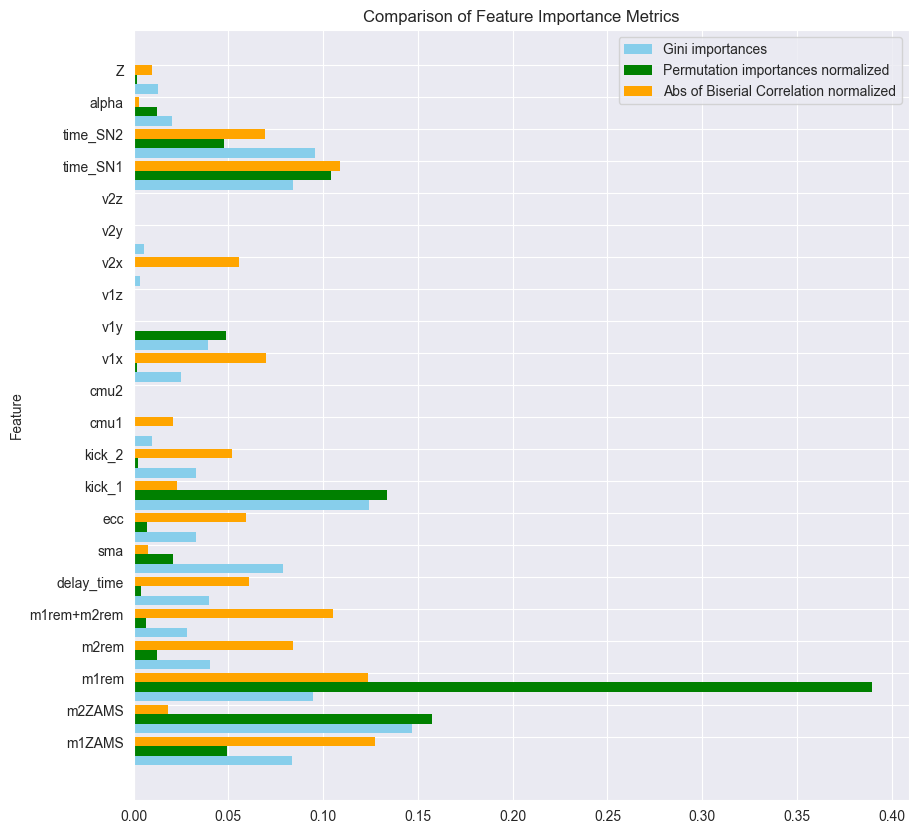

In [16]:
# plotting the normalized importances
bar_width = 0.3
fig, ax = plt.subplots(figsize=(10, 10))

index = np.arange(len(correlation_df))

ax.barh(index, importances['gini'], color='skyblue', height=bar_width, label='Gini importances',edgecolor='none')
ax.barh(index + bar_width, np.abs(importances['permutation'])/np.abs(importances['permutation']).sum(), color='green', height=bar_width, label='Permutation importances normalized',edgecolor='none')
ax.barh(index+2*bar_width, np.abs(correlation_df.iloc[:,0])/np.abs(correlation_df.iloc[:,0]).sum(), color='orange', height=bar_width, label='Abs of Biserial Correlation normalized',edgecolor='none')

ax.set_yticks(index+5/2*bar_width)
ax.set_yticklabels(correlation_df.index, va='top')

ax.set_ylabel('Feature')
ax.set_title('Comparison of Feature Importance Metrics')

ax.legend()
plt.show()


In the three metrics are used the permutation one shows a more marked separation in the importance of the features: the m1rem is the most pronounced feature; the other metrics do not emphasize this but they not totally disagree: looking at the table above (and the figure above) we see parameters are highlighted at least twice, if not they are not however the most important of the metric.
We can anyway consider the permutation the most reliable metric because it´s the one which randomizes more data, it´s not biased (unlike the Gini importance).

## Reduced Data Set

The importance assessment is repeated with a reduced data set. This data set contains the parameters that were suggested to be important and marked as bold in the project assignment. The methods are exactly the same as the ones used for the full data set.

In [17]:
data_reduced = data[["m1ZAMS", "m2ZAMS", "m1rem", "m2rem", "delay_time", "sma", "ecc", "alpha", "Z"]]
data_reduced

,m1ZAMS,m2ZAMS,m1rem,m2rem,delay_time,sma,ecc,alpha,Z
0,24.1323,17.1893,9.5692,5.0020,141.1783,5.1703,0.258940,0.5,0.0002
1,69.5474,64.3689,28.4847,39.1186,9.2023,6.4328,0.055966,0.5,0.0002
2,106.6977,41.0318,39.9392,38.2094,2223.2639,35.8880,0.041435,0.5,0.0002
3,74.3594,54.3256,30.1523,37.4020,8.7628,6.0720,0.041342,0.5,0.0002
4,116.6000,63.2642,41.9604,42.9817,2636.2197,40.0410,0.079504,0.5,0.0002
...,...,...,...,...,...,...,...,...,...
2963577,49.5343,41.7016,4.9807,4.6760,10772.9297,11.8280,0.251980,5.0,0.0200
2963578,89.2801,62.1861,7.3304,5.1195,16.0614,462.4200,0.999370,5.0,0.0200
2963579,36.4361,27.1551,4.0565,3.2400,2200.2712,212.1500,0.993170,5.0,0.0200
2963580,73.1220,37.7591,8.2607,4.8831,6547.9141,302.6300,0.988970,5.0,0.0200


Splitting the reduced data set:

In [18]:
X = data_reduced
y = data["CE"]

# split data into training and test set (10% to 90%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.9, random_state=100)

Initialising and training the Random Forest model:

In [19]:
# initialise random forest classifier
# using n_jobs=-1 to run parallel jobs using all processors
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# time the process
ts = time.time()
clf.fit(X_train, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

Training time: 30.12 s
Training accuracy:  1.0
Test accuracy:  0.997928183009751


Assessing the Gini and permutation importances:

In [20]:
# save params + importances to dataframe
importances_reduced = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_),
                           columns=["param", "gini"])

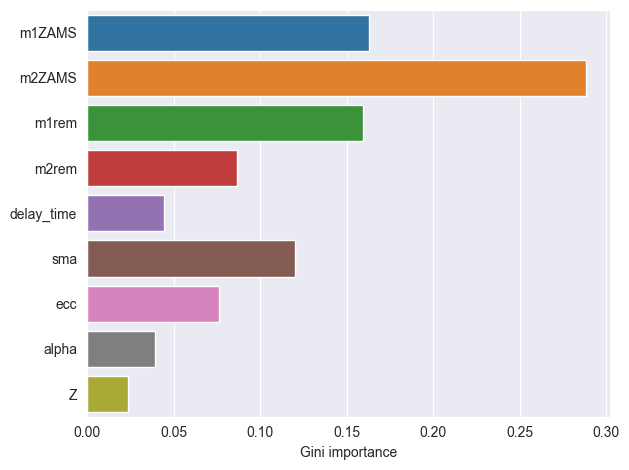

In [21]:
# plot Gini importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='gini', data=importances_reduced, ax=ax, hue='param')
ax.set_ylabel('')
ax.set_xlabel('Gini importance')
fig.tight_layout()
plt.show()

In [22]:
# compute permutation feature importances
# warning: takes a lot of time to compute!
ts = time.time()
result = permutation_importance(clf, X_test[::9], y_test[::9], n_repeats=5, random_state=0, n_jobs=-1)
print("importance calculation time: {:.2f} s".format(time.time() - ts))
# save importances to DataFrame      
importances_reduced['permutation'] = result.importances_mean
importances_reduced['permutation_std'] = result.importances_std

importance calculation time: 41.61 s


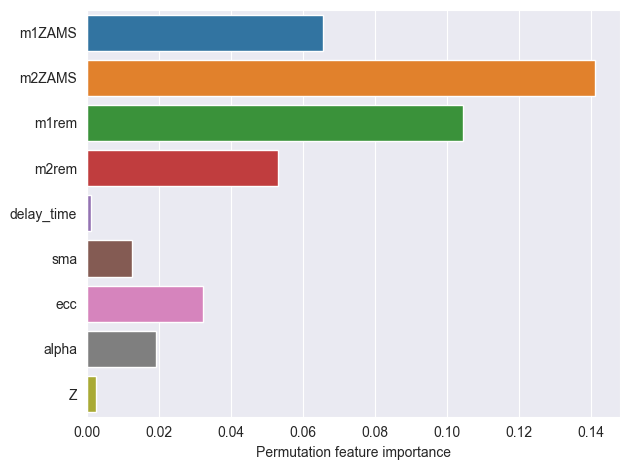

In [23]:
# plot permutation importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='permutation', data=importances_reduced, ax=ax, hue='param')
ax.set_ylabel('')
ax.set_xlabel('Permutation feature importance')
fig.tight_layout()
plt.show()

With the reduced data set, the two importance metrics assign high importances to the mass parameters, with m2ZAMS being deemed the most important. They disagree about the importance of the semimajor axis (sma) and the eccentricity (ecc), but assign low importances to the metallicity Z and the delay time.